# Combine adiabatic master equation with spin-fluctuator model
In this example notebook, we solve the master equation of the following form
\begin{equation}
    \dot{\rho} = - i [-Z + \delta(s)Z, \rho] + \mathcal{L}(\rho)
\end{equation}
via trajectory method. In above expression, $\delta(s)$ is a classical stochastic process generated by summing multiple telegraph processes together. $\mathcal{L}$ is the Lindblad operator in the Davies form.

In [2]:
using OrdinaryDiffEq
using Plots
using Revise
using QuantumAnnealingTools
using StatsBase

# generate a list of γ in a log-uniform fashion
function build_γ(start, stop, length)
    log_start = log10(start)
    log_stop = log10(stop)
    10 .^ (range(log_start, log_stop, length=length))
end

H = DenseHamiltonian([(s)->1.0], [-σz], unit=:ħ)
u0 = PauliVec[1][1]


coupling = ConstantCouplings(["Z"], unit=:ħ)
num = 10
# The values of b created here are in angular frequencies unit
bvec = 0.2 * ones(num)
γvec = build_γ(0.01, 1, num)
fluctuator_ensemble = EnsembleFluctuator(bvec, γvec);

interaction_fluctuator = Interaction(coupling, fluctuator_ensemble)

ohmic_bath = Ohmic(1e-4, 4, 16)
interaction_ohmic = Interaction(coupling, ohmic_bath)

interactions = InteractionSet(interaction_fluctuator, interaction_ohmic)
annealing = Annealing(H, u0, interactions=interactions)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0 with size: (2,)
custom system bath interactions

In [167]:
tf = 20
prob, callback = build_ensemble_problem(annealing, tf, :ame_trajectory, ω_hint = range(-2, 2, length=100));

In [168]:
s_list = range(0,1,length=200)
sol = solve(prob, Tsit5(), EnsembleSerial(); trajectories=1000, callback=callback, abstol=1e-6, reltol=1e-6, saveat=s_list);

In [169]:
dataset = []
for s in s_list
    push!(dataset, [real(normalize(so(s))' * σx * normalize(so(s))) for so in sol])
end

pop_mean = []
pop_rmse = []
for data in dataset
    p_mean = sum(data)/1000
    p_rmse = sqrt(sum((x)->(x-p_mean)^2, data))/1000
    push!(pop_mean, p_mean)
    push!(pop_rmse, 2*p_rmse)
end

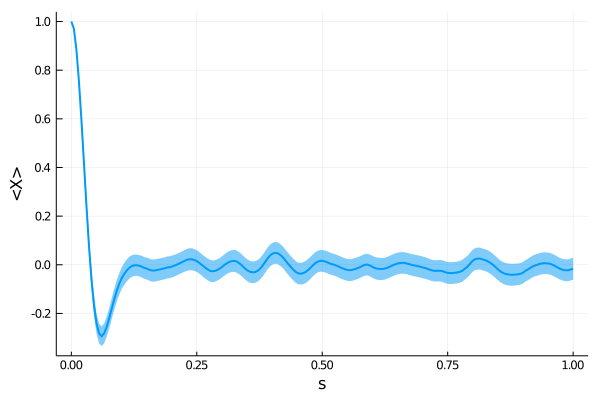

In [172]:
plot(s_list, pop_mean, ribbon=pop_rmse, label="", linewidth=2)
xlabel!("s")
ylabel!("<X>")

## Use `DEDataArray` to recored jump probability and noise value for each trajectory
Finally, we can use `DEDataArray` to record the jump probabilities and noise value for each trajectory:

In [137]:
mutable struct DEAMEArray{T,N} <: DEDataArray{T,N}
    x::Array{T,N}
    r::Float64
    n::Vector{Float64}
end

de_wrapper(x) = DEAMEArray(x, 1.0, [1.0]);

In [136]:
tf = 20
prob, callback = build_ensemble_problem(annealing, tf, :ame_trajectory, ω_hint = range(-2, 2, length=100),
    de_array_constructor=de_wrapper, fluctuator_de_field=:n, ame_trajectory_de_field=:r);

In [150]:
s_list = range(0,1,length=200)
sol = solve(prob, Tsit5(), EnsembleSerial(); trajectories=1, 
    callback=callback, abstol=1e-6, reltol=1e-6);

In [151]:
r_list = [sol[1](s).r for s in s_list]
n_list = [u.n[1] for u in sol[1].u];

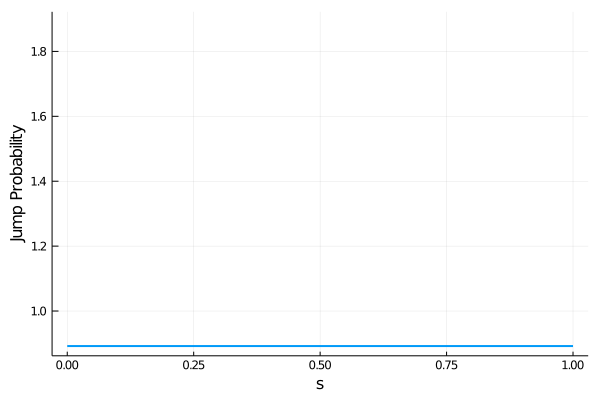

In [166]:
plot(s_list, r_list, label="", linewidth=2)
xlabel!("s")
ylabel!("Jump Probability")

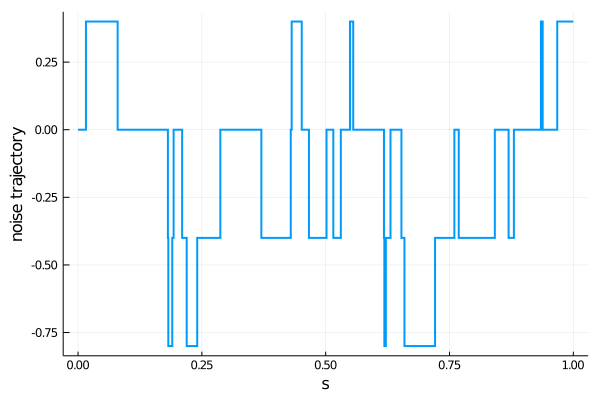

In [163]:
plot(sol[1].t, n_list, linewidth=2, label="")
xlabel!("s")
ylabel!("noise trajectory")

## Use `InstPulseControl` with the hybrid noise model

In [173]:
mutable struct DEAMEPulseArray{T,N} <: DEDataArray{T,N}
    x::Array{T,N}
    r::Float64
    state::Int
    n::Vector{Float64}
end

de_wrapper(x) = DEAMEPulseArray(x, 1.0, 1, [1.0]);

In [175]:
control = InstDEPulseControl([0.5], (x)->σx, :state)
annealing = Annealing(H, u0, interactions=interactions, control=control)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0 with size: (2,)
custom system bath interactions

In [178]:
tf = 20
prob, callback = build_ensemble_problem(annealing, tf, :ame_trajectory, ω_hint = range(-2, 2, length=100),
    de_array_constructor=de_wrapper, fluctuator_de_field=:n, ame_trajectory_de_field=:r);
sol = solve(prob, Tsit5(), EnsembleSerial(); trajectories=1, 
    callback=callback, abstol=1e-6, reltol=1e-6);

In [179]:
s_list = range(0,1,length=200)
r_list = [sol[1](s).r for s in s_list]
n_list = [u.n[1] for u in sol[1].u]
state_list = [u.state for u in sol[1].u];

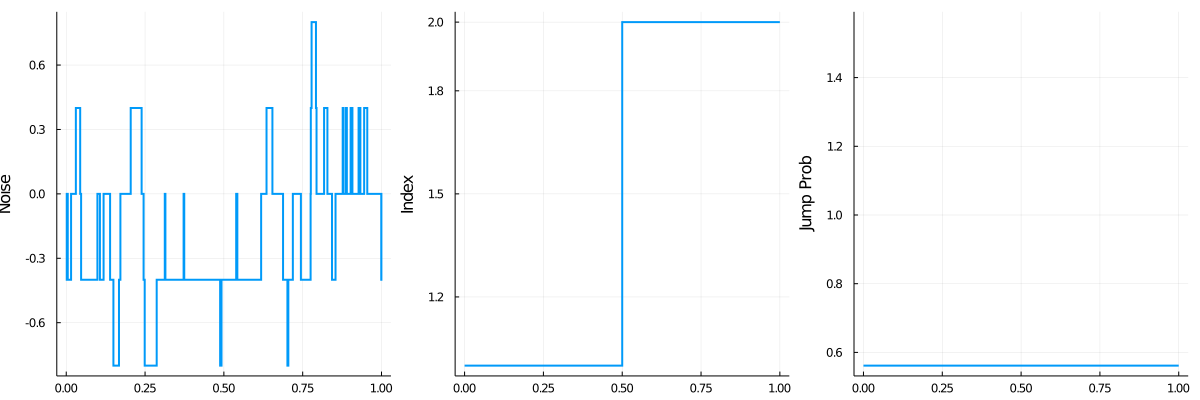

In [199]:
p1 = plot(sol[1].t, n_list, linewidth=2, label="")
ylabel!("Noise")
p2 = plot(sol[1].t, state_list, label="", linewidth=2)
ylabel!("Index")
p3 = plot(s_list, r_list, label="", linewidth=2)
ylabel!("Jump Prob")
plot(p1, p2, p3, layout=(1,3), size=(1200,400))